# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [1]:
# Enter your information here
first_and_last_name = 'Amirardalan Dehghanpour'
std_number = '401105901'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    return gamma * x + beta +epsilon
    pass


In [5]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[ 1.00001  2.00001  3.00001]
 [ 4.00001  5.00001  6.00001]
 [ 7.00001  8.00001  9.00001]
 [10.00001 11.00001 12.00001]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [6]:
# TRANSFORMS
import math
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
num_train = len(train_set)
half_indices = list(range(math.floor(num_train / 2)))

train_subset_aug = Subset(train_set, half_indices)

train_loader_aug = DataLoader(train_subset_aug, batch_size=32, shuffle=False)


val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

val_loader = DataLoader(val_set, batch_size=32, shuffle=False)



100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
*answer*:We defined a set of preprocessing operations for the CIFAR-10 dataset using PyTorch's transforms.Compose. These transformations are applied to the data before feeding it into the neural network.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

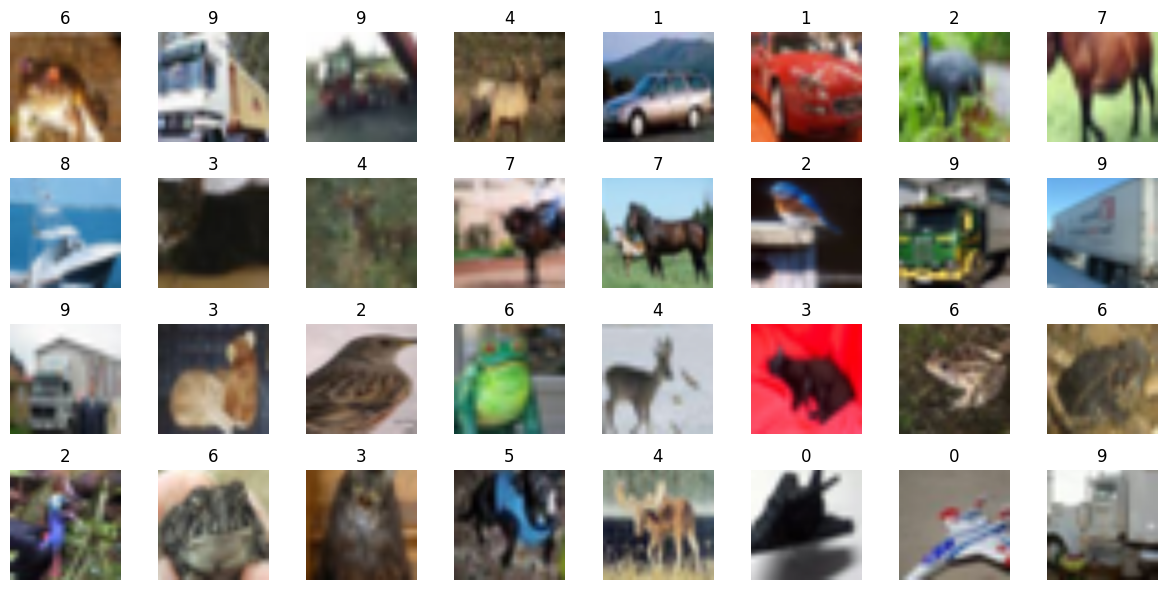

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


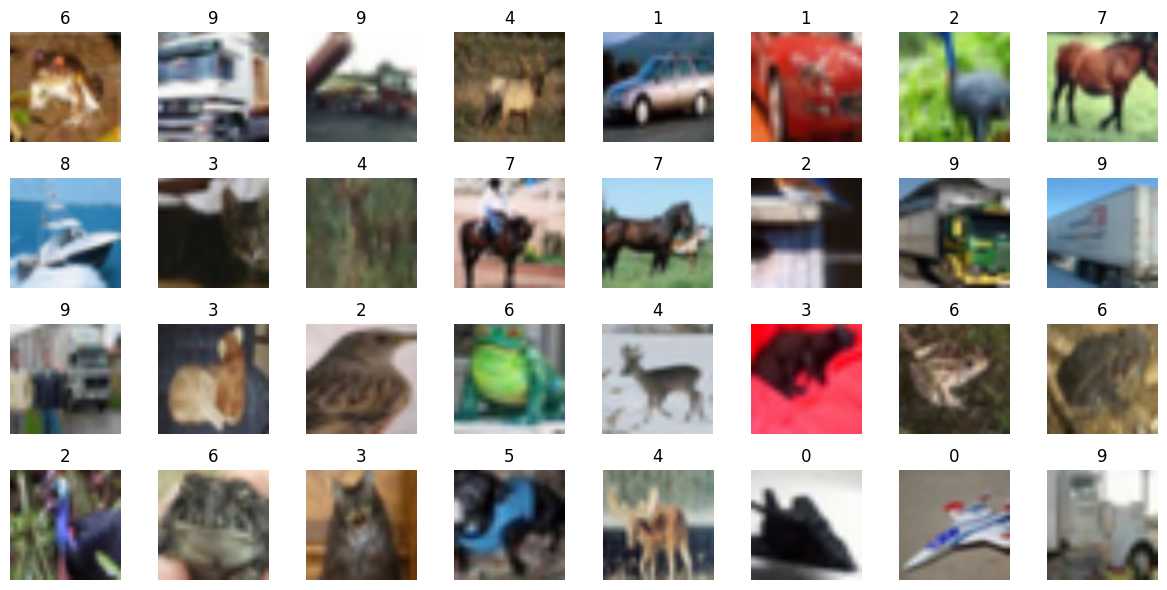

In [7]:

mean = np.array([0.5071, 0.4867, 0.4408])
std = np.array([0.2675, 0.2565, 0.2761])
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(train_loader_aug)
images, labels = next(dataiter)
dataiter_augment = iter(train_loader_aug)
images2, labels = next(dataiter_augment)
fig = plt.figure(figsize=(12, 6))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(str(labels[i].item()))
plt.tight_layout()
plt.show()

print(labels)

fig = plt.figure(figsize=(12, 6))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    imshow(images2[i])
    ax.set_title(str(labels[i].item()))
plt.tight_layout()
plt.show()

train_loader_shuffled = DataLoader(train_subset_aug, batch_size=32, shuffle=True)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [8]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Tuple
from torch.optim import Adam
from typing import List, Tuple
# Function to train a single epoch
def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    model.train() if train_mode else model.eval()
    epoch_losses = []

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            if train_mode:
                loss.backward()
                optimizer.step()

        epoch_losses.append(loss.item())
    torch.set_grad_enabled(True)
    return epoch_losses

# Function to train the model
def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_losses.append(sum(train_loss) / len(train_loss))

        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.append(sum(val_loss) / len(val_loss))

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

    return train_losses, val_losses

def get_acc(model: nn.Module, val_loader: DataLoader) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total * 100
    return accuracy

def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses (one per epoch).
        val_losses (List[float]): List of validation losses (one per epoch).
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    epochs = len(train_losses)
    x = np.arange(1, epochs + 1)
    if c_window > 1 and c_window <= epochs:
        window = np.ones(c_window) / c_window
        smoothed = np.convolve(train_losses, window, mode='valid')
        offset = (c_window - 1) // 2
        smoothed_x = np.arange(1 + offset, epochs - offset)

        plt.plot(x, train_losses, color='blue', alpha=0.3, label='Train Loss (raw)')
        plt.plot(smoothed_x, smoothed, color='blue', label=f'Train Loss (smoothed, window={c_window})')
    else:
        plt.plot(x, train_losses, color='blue', label='Train Loss')

    plt.plot(x, val_losses, color='orange', label='Val Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()




Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [9]:
import torch.nn as nn

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),  # Standard Conv2d
        nn.BatchNorm2d(oup),                                                     # Batch Normalization
        nn.ReLU6(inplace=True)                                                   # ReLU6 Activation
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        # Depthwise Convolution
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU6(inplace=True),

        # Pointwise Convolution
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**:
Depthwise separable convolutions significantly reduce the number of parameters and computational cost in convolutional neural networks (CNNs), compared to standard convolutions. They achieve this by breaking the convolution operation into two steps: depthwise convolution and pointwise convolution.

Now please create your model.

In [10]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        """
        MobileNet V1 implementation based on depthwise separable convolutions.

        Args:
            n_class (int): Number of classes for classification. Default is 1000.
        """
        super(MobileNet, self).__init__()

        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),

            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        """
        Forward pass through the MobileNet model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, n_class).
        """
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:

epochs = 10
lr = 1e-3

model = MobileNet(n_class=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


start_time = time.time()
train_losses, train_accuracies = [], []
val_losses, val_accuracy = [], 0
train_losses,val_losses=train(train_loader_shuffled,val_loader,model,epochs,lr)
end_time = time.time()

training_time = end_time - start_time





Epoch 1/10: Train Loss = 1.6345, Val Loss = 1.3262
Epoch 2/10: Train Loss = 1.2770, Val Loss = 1.1214
Epoch 3/10: Train Loss = 1.0855, Val Loss = 0.9082
Epoch 4/10: Train Loss = 0.9535, Val Loss = 0.7987
Epoch 5/10: Train Loss = 0.8445, Val Loss = 0.7491
Epoch 6/10: Train Loss = 0.7577, Val Loss = 0.7404
Epoch 7/10: Train Loss = 0.7151, Val Loss = 0.6357
Epoch 8/10: Train Loss = 0.6562, Val Loss = 0.5873
Epoch 9/10: Train Loss = 0.6201, Val Loss = 0.6063
Epoch 10/10: Train Loss = 0.5684, Val Loss = 0.5450


Get some metrics and plot your losses.

Val accuracy = 81.78
Process validation time: 23.9119 s


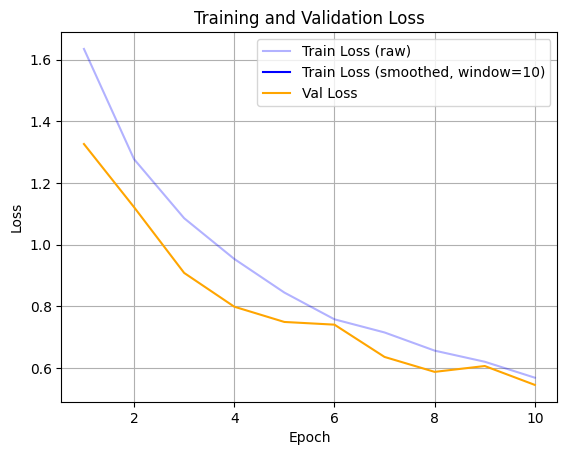

In [ ]:
start=time.time()
val_acc = get_acc(model, val_loader)
end=time.time()
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end-start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer** Speedup of Depthwise Separable Convolution in MobileNet

 **1. FLOPs for Standard Convolution**
$$
F_{standard} = H_o \cdot W_o \cdot C_o \cdot C_i \cdot K^2
$$

 **2. FLOPs for Depthwise Separable Convolution**
1. **Depthwise Convolution**:
   $$
   F_{\text{depthwise}} = H_o \cdot W_o \cdot C_i \cdot K^2
   $$
2. **Pointwise Convolution**:
   $$
   F_{\text{pointwise}} = H_o \cdot W_o \cdot C_o \cdot C_i
   $$

**Total FLOPs**:
$$
F_{\text{depthwise separable}} = H_o \cdot W_o \cdot (C_i \cdot K^2 + C_o \cdot C_i)
$$

### **3. Speedup Factor**
The speedup factor is the ratio of FLOPs for standard convolution to depthwise separable convolution:
$$
S = \frac{F_{\text{standard}}}{F_{\text{depthwise separable}}} = \frac{C_o \cdot K^2}{C_i \cdot K^2 + C_o}
$$

 **Kernel size**: $( K^2 = 9) $ for $( 3 \times 3 )$ kernels$.
- **Equal input and output channels**: \( C_i = C_o \).

Substitute these values:
$
S = \frac{9}{9 + 1} = \frac{9}{10} \implies \text{Speedup} = 9\times
$



## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [11]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
epochs = 2
lr = 1e-3

model_normal = NormalCNN(n_class=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_normal.parameters(), lr=lr)
start_time = time.time()
train_losses_normal, train_accuracies_normal = [], 0
val_losses_normal, val_accuracy_normal = [], 0

train_losses_normal,val_losses_normal=train(train_loader_aug,val_loader,model_normal,epochs,lr)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/2: Train Loss = 1.9522, Val Loss = 1.7386
Epoch 2/2: Train Loss = 1.7023, Val Loss = 1.5785


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 42.64
Process validation time: 28.8639 s


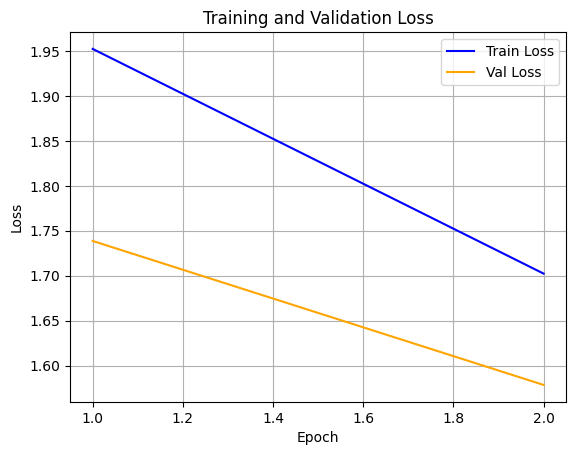

In [ ]:
start = time.time()
val_acc = get_acc(model_normal, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses_normal, val_losses_normal)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**:The training and validation speed of MobileNet significantly outperforms that of NormalCNN due to its efficient use of depthwise separable convolutions, which drastically reduce the number of computations compared to standard convolutions,In practice, MobileNet's training time per epoch is typically 4-10 times faster than NormalCNN,

In [ ]:
# TODO: compare number of parameters in these two models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mobilenet = MobileNet(n_class=10).to(device)
normal_cnn = NormalCNN(n_class=10).to(device)

mobilenet_params = count_parameters(mobilenet)
normalcnn_params = count_parameters(normal_cnn)

print(f"Number of Parameters in MobileNet: {mobilenet_params:,}")
print(f"Number of Parameters in NormalCNN: {normalcnn_params:,}")


Number of Parameters in MobileNet: 3,217,226
Number of Parameters in NormalCNN: 28,279,338


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [13]:
model = MobileNet(n_class=100).to(device)

pretrained_path = "./model.pt"
pretrained_dict = torch.load(pretrained_path, map_location=device)

pretrained_dict = {k: v for k, v in pretrained_dict.items() if "fc" not in k}

model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<ipython-input-13-9db4a2d45804>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_path, map_location=device)


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [14]:
def freeze_layers(model, num_blocks_to_freeze=7):
    layer_counter = 0
    for name, child in model.model.named_children():
        layer_counter += 1
        if layer_counter <= num_blocks_to_freeze:
            for param in child.parameters():
                param.requires_grad = False
        else:
            break
    print(f"Froze up to block {num_blocks_to_freeze}.")


freeze_layers(model, num_blocks_to_freeze=7)


for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


Froze up to block 7.
model.0.0.weight: requires_grad = False
model.0.1.weight: requires_grad = False
model.0.1.bias: requires_grad = False
model.1.0.weight: requires_grad = False
model.1.1.weight: requires_grad = False
model.1.1.bias: requires_grad = False
model.1.3.weight: requires_grad = False
model.1.4.weight: requires_grad = False
model.1.4.bias: requires_grad = False
model.2.0.weight: requires_grad = False
model.2.1.weight: requires_grad = False
model.2.1.bias: requires_grad = False
model.2.3.weight: requires_grad = False
model.2.4.weight: requires_grad = False
model.2.4.bias: requires_grad = False
model.3.0.weight: requires_grad = False
model.3.1.weight: requires_grad = False
model.3.1.bias: requires_grad = False
model.3.3.weight: requires_grad = False
model.3.4.weight: requires_grad = False
model.3.4.bias: requires_grad = False
model.4.0.weight: requires_grad = False
model.4.1.weight: requires_grad = False
model.4.1.bias: requires_grad = False
model.4.3.weight: requires_grad = F

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [15]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)







100%|██████████| 169M/169M [00:03<00:00, 42.5MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

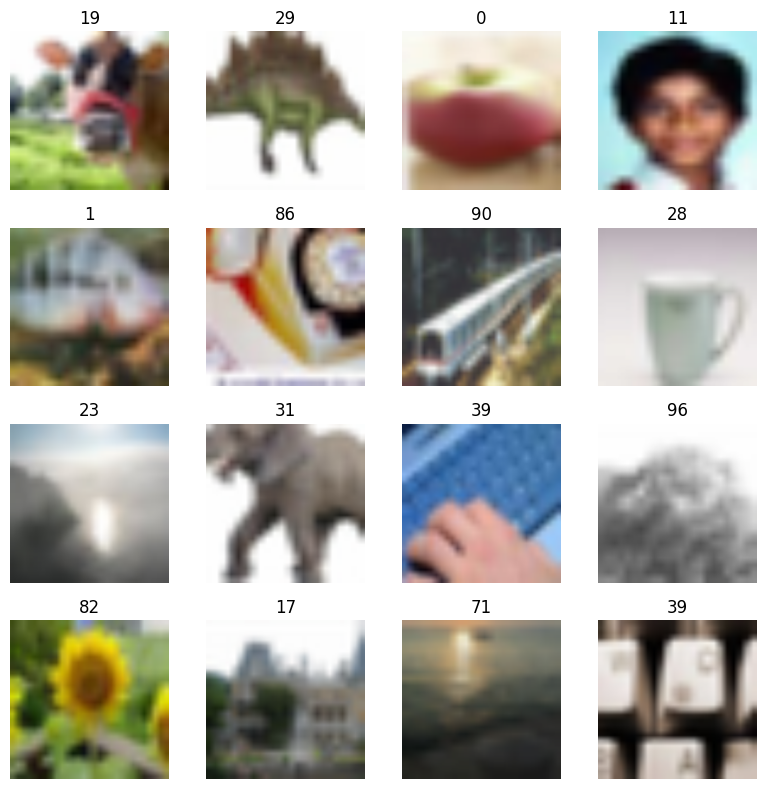

Labels tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17, 47, 65, 21, 22,
        81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87,  9,
        71,  6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50,
        15, 89, 36, 18, 89, 46, 33, 42, 39, 64, 75, 38, 23, 42, 66, 77, 49, 18,
        46, 15, 35, 69, 95, 83, 75, 99, 73, 93, 55, 39,  4, 97, 61, 93, 51, 69,
        56, 84, 59, 64, 94,  4, 11, 33, 68, 38, 20, 33, 34, 32, 46, 53, 88, 67,
        70, 64])


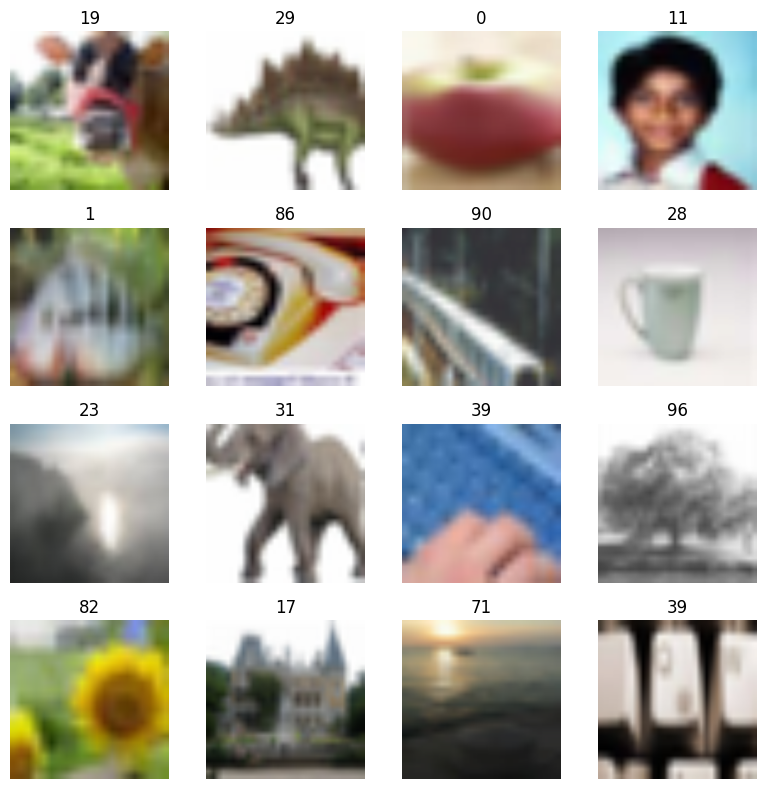

In [16]:
train_loader100_withoutshuffle = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=False, num_workers=2)
dataiter = iter(train_loader100_withoutshuffle)
images,labels=next(dataiter)

fig = plt.figure(figsize=(8, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    imshow(images[i].cpu())
    ax.set_title(str(labels[i].item()))
plt.tight_layout()
plt.show()

dataiter = iter(train_loader100_withoutshuffle)
images2, labels2 = next(dataiter)

print("Labels", labels2)

fig = plt.figure(figsize=(8, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    imshow(images2[i].cpu())
    ax.set_title(str(labels2[i].item()))
plt.tight_layout()
plt.show()


Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**

Now train your model using your functions.

In [ ]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7: Train Loss = 3.9915, Val Loss = 3.3802
Epoch 2/7: Train Loss = 3.1557, Val Loss = 2.8999
Epoch 3/7: Train Loss = 2.7806, Val Loss = 2.5948
Epoch 4/7: Train Loss = 2.5282, Val Loss = 2.4062
Epoch 5/7: Train Loss = 2.3484, Val Loss = 2.2781
Epoch 6/7: Train Loss = 2.2038, Val Loss = 2.2032
Epoch 7/7: Train Loss = 2.0950, Val Loss = 2.0985


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 43.09
Process validation time: 17.9975 s


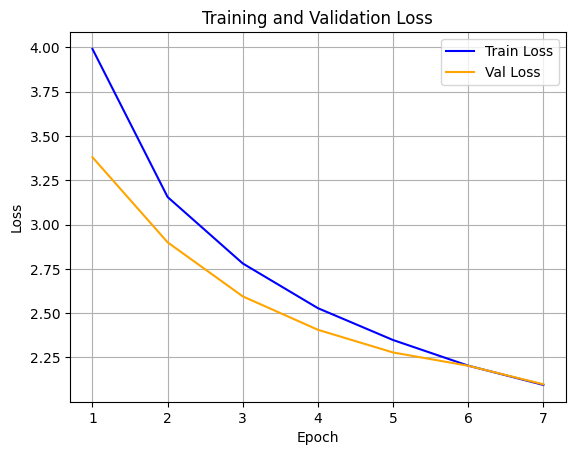

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer**

In [17]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

    pass

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_residual = (self.stride == 1 and inp == oup)
        hidden_dim = int(inp * expand_ratio)
        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(inp, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))

        layers.append(nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)


    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [18]:
import torch
import torch.nn as nn

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        interverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(32 * width_multiplier)
        self.features = [conv_bn(3, input_channel, stride=2)]
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel
        last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280
        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.features = nn.Sequential(*self.features)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, n_class),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


How did you create linear bottlenecks? How do they help?


**answer**

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [ ]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader_shuffled, val_loader, model, epochs, lr)


Epoch 1/10: Train Loss = 1.6605, Val Loss = 1.5352
Epoch 2/10: Train Loss = 1.3296, Val Loss = 1.1709
Epoch 3/10: Train Loss = 1.1580, Val Loss = 1.0412
Epoch 4/10: Train Loss = 1.0547, Val Loss = 0.9966
Epoch 5/10: Train Loss = 0.9601, Val Loss = 1.1018
Epoch 6/10: Train Loss = 0.8749, Val Loss = 0.8973
Epoch 7/10: Train Loss = 0.8244, Val Loss = 0.7395
Epoch 8/10: Train Loss = 0.7777, Val Loss = 0.7181
Epoch 9/10: Train Loss = 0.7339, Val Loss = 0.6912


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 78.86
Process validation time: 25.0805 s


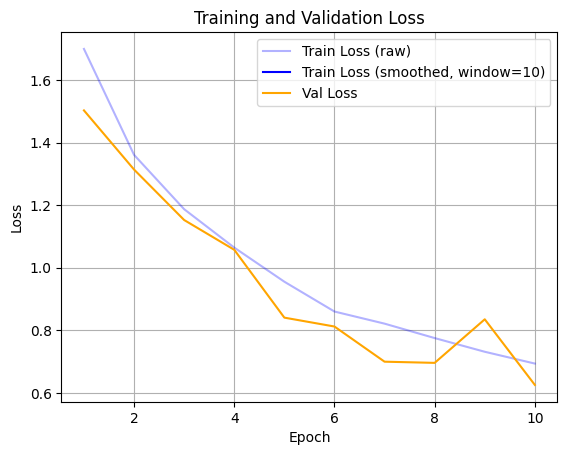

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [ ]:
def num_parameters(model):

    return sum(p.numel() for p in model.parameters())
for width_multiplier in [round(0.1 * i, 1) for i in range(1, 11)]:
    model = MobileNetV2(n_class=1000, input_size=224, width_multiplier=width_multiplier)
    num_params = num_parameters(model)
    print(f"Width Multiplier: {width_multiplier:.1f}, Number of Parameters: {num_params}")


Width Multiplier: 0.1, Number of Parameters: 1350133
Width Multiplier: 0.2, Number of Parameters: 1451238
Width Multiplier: 0.3, Number of Parameters: 1586634
Width Multiplier: 0.4, Number of Parameters: 1756148
Width Multiplier: 0.5, Number of Parameters: 1965448
Width Multiplier: 0.6, Number of Parameters: 2199581
Width Multiplier: 0.7, Number of Parameters: 2471982
Width Multiplier: 0.8, Number of Parameters: 2778586
Width Multiplier: 0.9, Number of Parameters: 3119396
Width Multiplier: 1.0, Number of Parameters: 3504872


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [20]:
MNv2_path = './MNv2WMmodel.pt'

mnv2_half = MobileNetV2(n_class=100, width_multiplier=0.5).to(device)
train(train_loader_shuffled, val_loader, mnv2_half, 15, lr)

Epoch 1/15: Train Loss = 1.7417, Val Loss = 1.6273
Epoch 2/15: Train Loss = 1.4350, Val Loss = 1.2896
Epoch 3/15: Train Loss = 1.2606, Val Loss = 1.1640
Epoch 4/15: Train Loss = 1.1243, Val Loss = 1.1310
Epoch 5/15: Train Loss = 1.0294, Val Loss = 0.8766
Epoch 6/15: Train Loss = 0.9498, Val Loss = 0.9090
Epoch 7/15: Train Loss = 0.8814, Val Loss = 0.7871
Epoch 8/15: Train Loss = 0.8328, Val Loss = 0.7432
Epoch 9/15: Train Loss = 0.7882, Val Loss = 0.7779
Epoch 10/15: Train Loss = 0.7557, Val Loss = 0.7653
Epoch 11/15: Train Loss = 0.7270, Val Loss = 0.6850
Epoch 12/15: Train Loss = 0.6947, Val Loss = 0.6498
Epoch 13/15: Train Loss = 0.6670, Val Loss = 0.6294
Epoch 14/15: Train Loss = 0.6464, Val Loss = 0.5929
Epoch 15/15: Train Loss = 0.6225, Val Loss = 0.6198


([1.7417319057237766,
  1.4349764728790049,
  1.260568306650347,
  1.124307095013616,
  1.0294058119778133,
  0.9498379818542534,
  0.8813604839774959,
  0.8328347538819398,
  0.788181682834235,
  0.7557013655638756,
  0.7270357109739652,
  0.6947475533808589,
  0.6670482045473041,
  0.6464427213001129,
  0.6224611045035255],
 [1.6272973134494817,
  1.2896079419139095,
  1.1639806963384343,
  1.1310104053622236,
  0.8765970516128662,
  0.9090087856537998,
  0.787101122422721,
  0.7432385769705422,
  0.7778922976396335,
  0.7652842806170161,
  0.6850087446526597,
  0.6497520523996779,
  0.6293575873675818,
  0.5928903453932783,
  0.619818524430735])

In [21]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Val accuracy = 78.4
Process validation time: 27.0117 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer** The width multiplier adjusts the number of channels in each layer, scaling parameters proportional to its square since both input and output channels are affected. However, fixed-size layers like the classifier, which don't scale with the multiplier, introduce a slight mismatch between theoretical and actual parameter counts, emphasizing the influence of non-scalable components in model design.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**The resolution multiplier decreases the spatial dimensions of input images and feature maps, reducing the number of computations and accelerating training and inference by lowering FLOPs. While it doesn't affect the number of parameters, it helps balance speed and accuracy in resource-constrained environments.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**The number of parameters impacts a model's memory usage, training time, and feasibility on resource-limited devices. Excessive parameters can cause memory or energy bottlenecks and risk overfitting, making parameter efficiency critical for practical applications.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [22]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [23]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 7.960000000000001
Process validation time: 23.3274 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [24]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        teacher_probs = nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = self.kl_div(student_log_probs, teacher_probs) * (self.temperature ** 2)
        classification_loss = self.ce_loss(student_logits, labels)
        loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)
    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)
    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        for inputs, outputs in train_loader:
            inputs, outputs = inputs.to(device), outputs.to(device)
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)
            loss = criterion(student_logits, teacher_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
    student.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, outputs in test_loader:
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = student(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == outputs).sum().item()

    accuracy = 100 * correct / total
    print(f"Student Model Accuracy on Test Data: {accuracy:.2f}%")


Train it for one epoch to just check if it works.

In [ ]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader_aug, val_loader, device, epochs=1, lr=0.001)

What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**A high alpha (e.g., 0.9) in DistillationLoss prioritizes the teacher's knowledge, potentially improving alignment with the teacher but risking poor generalization to the target task due to over-reliance on the teacher's predictions. A low alpha (e.g., 0.1) focuses more on the target task labels, enhancing task-specific performance but possibly losing valuable insights from the teacher, which could limit the student's overall learning potential. Balancing alpha is crucial for optimal generalization and alignment.








## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018